### Imports and set up

In [55]:
%cd /Users/federicoclaudi/Documents/Github/BehaviourAnalysis

/Users/federicoclaudi/Documents/Github/BehaviourAnalysis


In [56]:
# %%
# imports
import sys
sys.path.append("./")
from Utilities.imports import *
import scipy.io
from scipy.spatial.distance import euclidean as distance


"""
    Test script to load and inspect data from 8 neuropixel mice from the cortex lab
    https://figshare.com/articles/Eight-probe_Neuropixels_rec
"""

'\n    Test script to load and inspect data from 8 neuropixel mice from the cortex lab\n    https://figshare.com/articles/Eight-probe_Neuropixels_rec\n'

## Variables

In [57]:
one_mouse = False

# ? Load spikes data
spikes_folder = "/Users/federicoclaudi/Dropbox (UCL - SWC)/Rotation_vte/Ephys_Datasets/spks"
mice =['Krebs','Waksman','Robbins']
tstarts = {'Krebs':3811,'Waksman':3633,'Robbins':3323}

frate = 100 # represent time in frames



## Data loading

In [58]:
# Data loading functions
def load_parsed_data():
    print("loading data")
    data = {}
    for f in os.listdir(spikes_folder):
        if ".npy" in f:
            data[f.split(".")[0]] = np.load(os.path.join(spikes_folder, f))
    return data


def parse_cortexlab_data():
    for mouse, tstart in tstarts.items():
        spikes = scipy.io.loadmat(os.path.join(spikes_folder,"spks{}_Feb18.mat".format(mouse)))["spks"]

        # spikes["st"] -> spike times in seconds  Has 8 arrays, one for each probe
        # spikes["clu"] -> clusted identity of each spike in st
        # spikes["Wheights"]) -> height of each cluster on the probe

        # Extract spike times and create a matrix neurons x time
        data = {}
        for probe in np.arange(8):
            print("Processing {} - probe {}".format(mouse, probe))
            clu = spikes["clu"][0][probe]
            sf = np.floor(spikes["st"][0][probe] * frate).astype(np.int32) # convert time in 
            # height = spikes["Wheights"][probe]

            clusters = np.unique(clu)
            maxt = np.max(sf) - tstart * frate

            # Create a matrix of timexcluster to contain all spikes from all units
            matrix = np.zeros((max(clusters)+1, maxt+1)).astype(np.int8)

            for t, c in zip(sf, clu):
                matrix[c, t - tstart * frate] = 1

            np.save(os.path.join(spikes_folder, "{}_probe_{}.npy".format(mouse, probe)), matrix)
        
        if one_mouse: break



In [59]:
# Load data
data = load_parsed_data()



loading data


## Compute stuff

In [88]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    # v1_u = unit_vector(v1)
    # v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)), -1.0, 1.0))
    

In [89]:
def get_derivatives(data):
    derivs, mean_derivs, nn = [], [], []
    for i, mtx in tqdm(data.items()):
        dmtx = np.diff(mtx, 1)
        derivs.append(dmtx)
        mean_derivs.append(np.mean(dmtx, 0))
        nn.append(mtx.shape[0])
    return derivs, mean_derivs, nn


def get_corr_data(mean_derivs, nn):
    corr_data = [[], [], []]
    
    for d, n in zip(mean_derivs, nn):
        corr_data[0].append(n)
        corr_data[1].append(np.mean(d))
        corr_data[2].append(np.std(d))
    return corr_data

## Plot stuff

In [106]:
%matplotlib inline
def plot_traces(mean_derivs, nn):
    # Plot stuff
    f, axarr = create_figure(subplots=True, ncols=8, nrows=3, sharex=True, sharey=True, figsize=(20, 16))

    for i, (mean_dt, n) in tqdm(enumerate(zip(mean_derivs, nn))):
        axarr[i].plot(mean_dt, color=grey, lw=.5, alpha=.7)
        axarr[i].plot(line_smoother(mean_dt, window_size=1001), color=red, lw=2)
        axarr[i].set(title="{}n".format(n)) # , ylabel="time dot product", xlabel="time (frames)")

def plot_mean_derivs(corr_data):
    f, ax = plt.subplots(figsize = (12, 12))
    ax.fill_between(corr_data[1]-corr_data[2], corr_data[1]+corr_data[2], color=white)
        
def plot_corr(corr_data, title):
    f, ax = plt.subplots(figsize = (12, 12))
    sns.regplot(np.log(corr_data[0]), np.log(corr_data[2]), color=green, order=1, ax=ax, truncate=True)
    ax.set(title=title, xlabel="# neurons", ylabel="$std(\Psi_j)$")
    
def compare_corr(corr_data, f_corr_data):
    f, ax = plt.subplots(figsize = (12, 12))
    sns.regplot(np.log(corr_data[0]), np.log(corr_data[2]), color=green, order=1, ax=ax, truncate=True, label="real")
    sns.regplot(np.log(f_corr_data[0]), np.log(f_corr_data[2]), color=red, order=1, ax=ax, truncate=True, label="fake")
    ax.legend()
    ax.set(xlabel="# neurons", ylabel="$std(\Psi_j)$")
    
    

# Simulated data

In [91]:
# Create a bunch of random probe data with variable number of units per probe
fake_data = {}
for i in tqdm(range(30)):
    nunits = np.random.randint(10, 1000, size=1)[0]
    mtx = np.random.random((nunits, 10000)) > .5
    fake_data[i] = mtx

100%|██████████| 30/30 [00:03<00:00,  8.32it/s]


In [92]:
# Analyse and compare real and fake data
print("analyse real")
derivs, mean_derivs, nn = get_derivatives(data)
corr_data = get_corr_data(mean_derivs, nn)

print("analyse fake")
f_derivs, f_mean_derivs, f_nn = get_derivatives(fake_data)
f_corr_data = get_corr_data(f_mean_derivs, f_nn)

  0%|          | 0/24 [00:00<?, ?it/s]

analyse real


  0%|          | 0/30 [00:00<?, ?it/s]

analyse fake


100%|██████████| 30/30 [00:02<00:00, 12.07it/s]


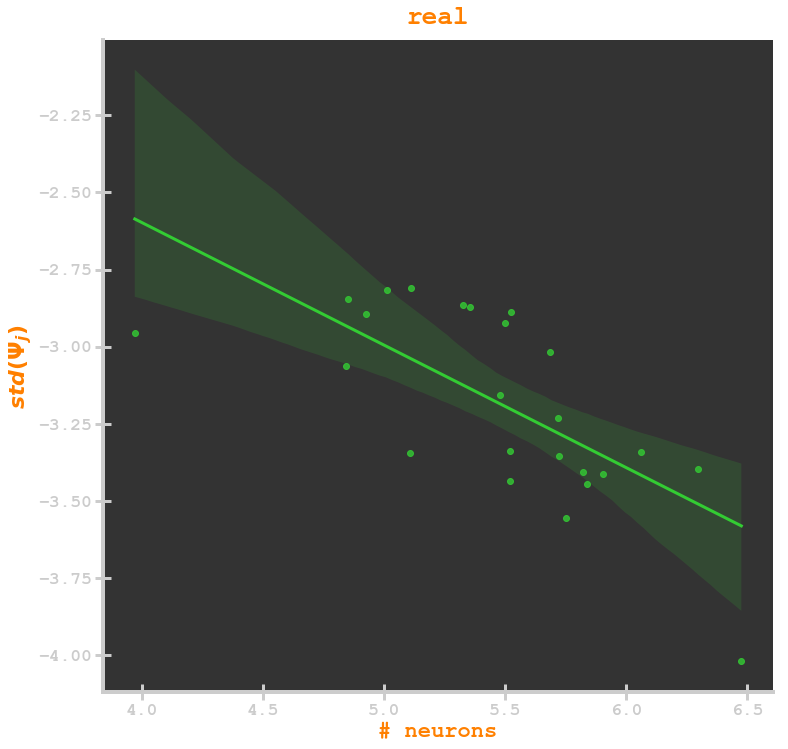

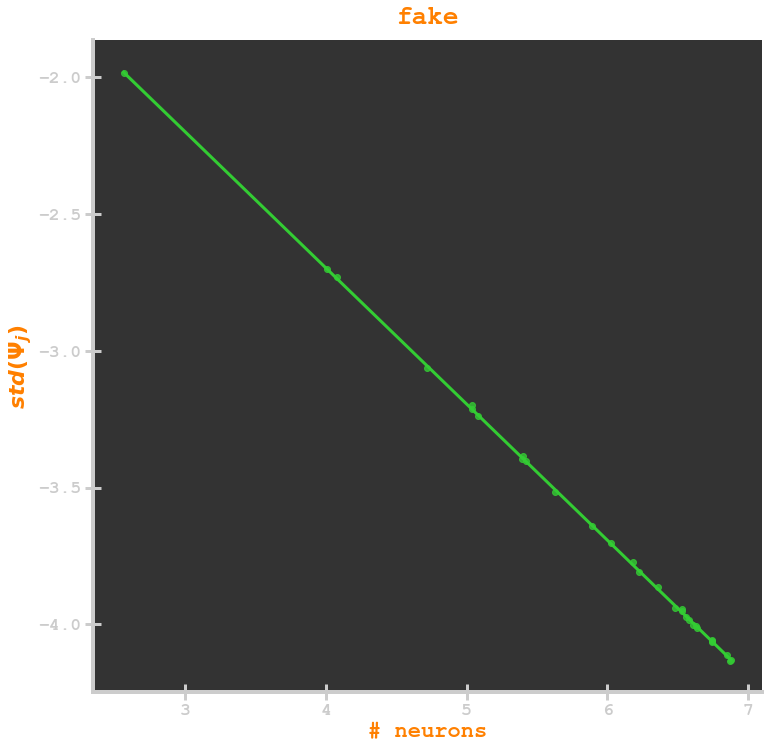

In [93]:
plot_corr(corr_data, "real")
plot_corr(f_corr_data, "fake")

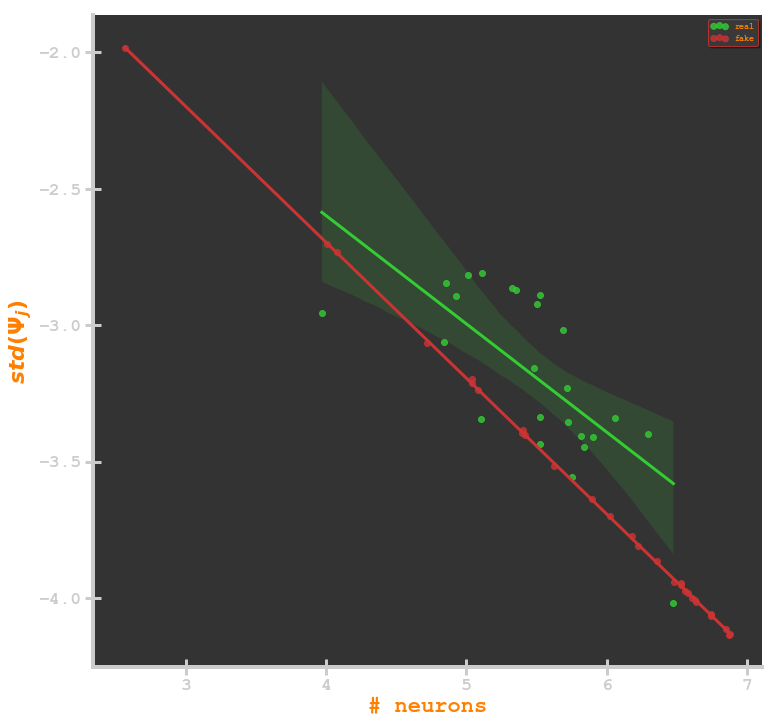

In [108]:
compare_corr(corr_data, f_corr_data)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

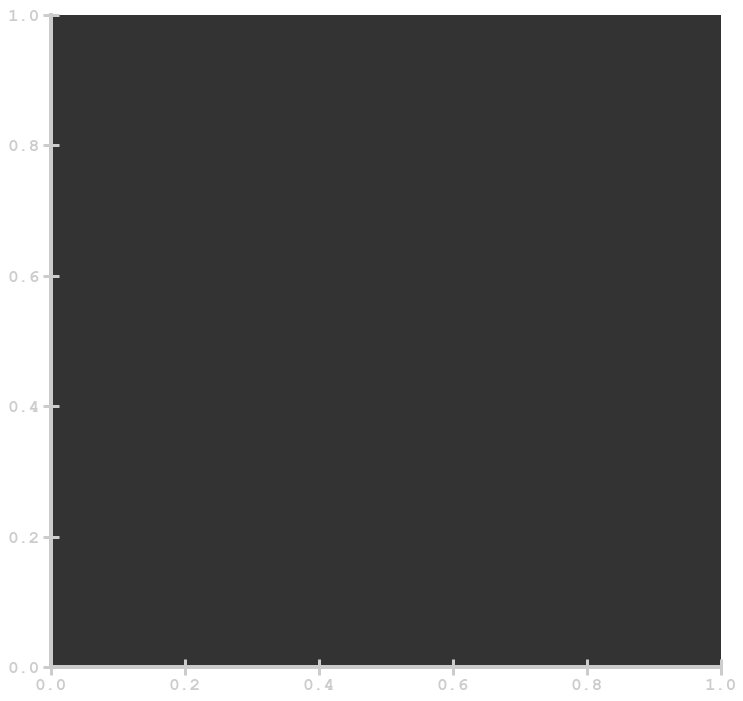

In [107]:
plot_mean_derivs(corr_data)

In [109]:
corr_data[1]

[1.655093536940274e-06,
 2.804874340153299e-06,
 2.3498885039744255e-06,
 3.8089718272486858e-06,
 1.492345112028184e-06,
 -1.2830558725009157e-06,
 2.0748153809932426e-06,
 4.559603565268057e-06,
 1.0444819496359472e-06,
 3.288723347110826e-06,
 5.839666795482876e-06,
 1.7196083011725503e-06,
 -9.37827772223875e-22,
 1.0019365429502141e-06,
 -2.0637705087194214e-07,
 6.223153445684258e-07,
 1.2875720838230436e-20,
 1.4881151682090858e-06,
 2.6209756682731785e-06,
 3.367955920192888e-07,
 7.586636681388066e-07,
 1.504492037099828e-06,
 9.353702787964913e-07,
 5.89639025199953e-07]